In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./insurance.csv")

# Задание 1

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
target = "charges"
num_features = []
cat_features = []
for c, t in df.dtypes.items():
    if c == target:
        continue
    elif t == np.int64:
        num_features.append(c)
    elif t == np.float64:
        num_features.append(c)
    else:
        cat_features.append(c)

In [7]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [8]:
onehot = OneHotEncoder(sparse_output=False, drop="first").fit(train[cat_features])
scaler = StandardScaler().fit(train[num_features])

def apply(data):
    res = data.copy()
    res[onehot.get_feature_names_out().tolist()] = onehot.transform(data[cat_features])
    res[num_features] = scaler.transform(data[num_features])
    res = res.drop(columns=cat_features)
    return res.drop(columns=[target]), res[target]

In [9]:
X, y = apply(train)
Xtest, ytest = apply(test)

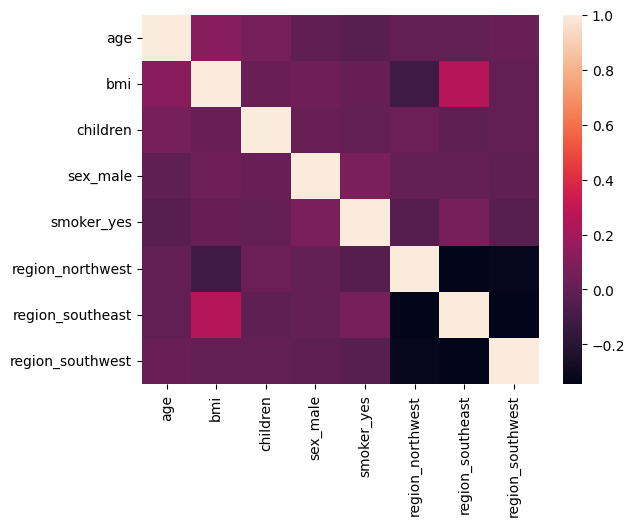

In [10]:
sns.heatmap(X.corr())
plt.show()

# Задание 2

In [11]:
class Regression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        raise Exception()

    def transform(self, X):
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
        return X_with_bias @ self.w

In [12]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

def train_and_eval(r: Regression):
    r.fit(X, y)
    pred = r.transform(Xtest)
    try:
        print(r.w)
    except:
        pass
    return {
        "mse": mean_squared_error(ytest, pred),
        "rmse": root_mean_squared_error(ytest, pred),
        "mape": mean_absolute_percentage_error(ytest, pred)
    }

In [13]:
class AnaliticRegression(Regression):
    def __init__(self):
        super().__init__()

    def fit(self, X, y):
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
        self.w = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
        return self

In [14]:
train_and_eval(AnaliticRegression())

[ 9034.41235502  3648.67080754  2002.42898927   533.65805737
  -265.3913387  23930.00940579  -292.51107731  -836.18617589
  -867.81931411]


{'mse': 32275850.35093538,
 'rmse': 5681.183886386303,
 'mape': 0.44114030583316194}

$\Delta L=2X^T(Xw-y)$

In [15]:
class NumericRegression(Regression):
    def __init__(self, lr=3e-4, num_iters=1000):
        super().__init__()
        self.num_iters = num_iters
        self.lr = lr

    def fit(self, X, y):
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
        self.w = np.zeros((X_with_bias.shape[1],))
        for _ in range(self.num_iters):
            grad = 2 * X_with_bias.T @ (X_with_bias @ self.w - y)
            self.w -= self.lr * grad
        return self

In [16]:
train_and_eval(NumericRegression())

[ 9034.41235502  3648.67080754  2002.42898927   533.65805737
  -265.3913387  23930.00940579  -292.51107731  -836.18617589
  -867.81931411]


{'mse': 32275850.350935373,
 'rmse': 5681.183886386302,
 'mape': 0.4411403058331604}

# Задание 3

$w^* = (X^TX + \alpha I)^{-1}X^Ty$

In [17]:
class AnaliticRegRegression(Regression):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    
    def fit(self, X, y):
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
        self.w = np.linalg.inv(X_with_bias.T @ X_with_bias + self.alpha * np.identity(X_with_bias.shape[1])) @ X_with_bias.T @ y
        return self

In [18]:
train_and_eval(AnaliticRegRegression())

[ 9008.28440922  3644.40626887  1997.72304829   533.70583078
  -242.14054819 23815.62707331  -258.15807252  -789.20230315
  -829.18050905]


{'mse': 32245508.80093324,
 'rmse': 5678.51290400341,
 'mape': 0.44390788335318937}

$\Delta L = 2 X^T (Xw - y) + 2 \alpha w$

In [19]:
class NumericRegRegression(Regression):
    def __init__(self, lr=3e-4, num_iters=1000, alpha=1.0):
        super().__init__()
        self.num_iters = num_iters
        self.lr = lr
        self.alpha = alpha

    def fit(self, X, y):
        X_with_bias = np.column_stack((np.ones(X.shape[0]), X))
        self.w = np.zeros((X_with_bias.shape[1],))
        for _ in range(self.num_iters):
            grad = 2 * X_with_bias.T @ (X_with_bias @ self.w - y) + 2 * self.alpha * self.w
            self.w -= self.lr * grad
        return self

In [20]:
train_and_eval(NumericRegRegression())

[ 9008.28440922  3644.40626887  1997.72304829   533.70583078
  -242.14054819 23815.62707331  -258.15807252  -789.20230315
  -829.18050905]


{'mse': 32245508.800933268,
 'rmse': 5678.512904003413,
 'mape': 0.44390788335319065}

# Задание 4

In [21]:
class ConstantPredictor:
    def __init__(self):
        self.pred = None

    def fit(self, X, y):
        self.pred = np.mean(y)

    def transform(self, X):
        return np.full((X.shape[0],), self.pred)

In [22]:
train_and_eval(ConstantPredictor())

{'mse': 138211323.65028468,
 'rmse': 11756.331215574213,
 'mape': 1.642468903244194}